In [1]:
import requests
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = 100

# Extracting for a single year

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3077064666.py:68: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")
/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3077064666.py:85: UserWarning: `keep_geom_type=True` in overlay resulted in 

                    Name  Total Population  Owner Occupied Households  \
0          Sarah McBride             44477                      11116   
1        Darius J. Brown             41343                       8493   
2   S. Elizabeth Lockman             39367                       6232   
3      Laura V. Sturgeon             40479                      12753   
4         Kyle Evans Gay             40613                      13195   
5       Russell Huxtable             53772                      21567   
6     Spiros Mantzavinos             42058                      12222   
7        David P. Sokola             45333                       9475   
8      John "Jack" Walsh             41935                       9992   
9    Stephanie L. Hansen             45317                      13877   
10        Bryan Townsend             42726                       9260   
11          Nicole Poore             53006                      14781   
12         Marie Pinkney             43838         

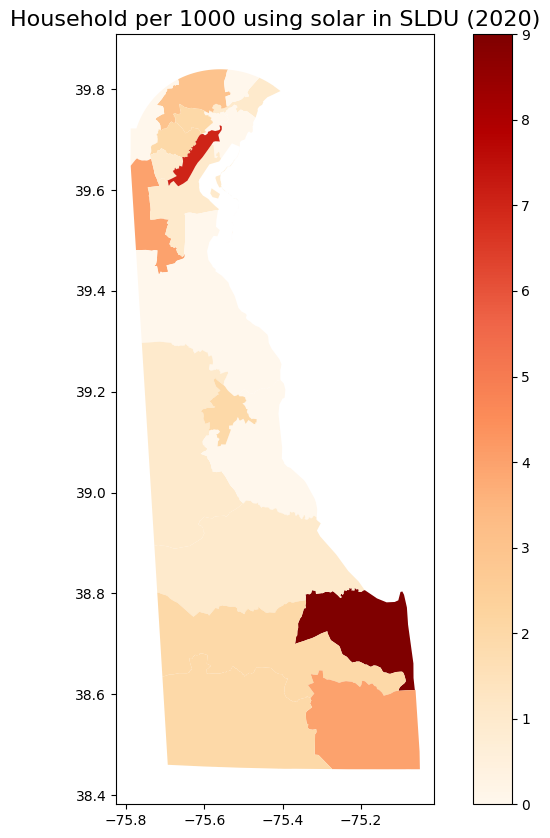

In [2]:
# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

EEIF_df = pd.read_csv("/Users/kamran/Downloads/DSHA/Energy_Efficiency_Investment_Fund__EEIF__Grants__FY_2017_to_Present.csv")

# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

# Create a GeoDataFrame from the latitude and longitude columns and engineering year feature
geometry = gpd.points_from_xy(EEIF_df['Longitude'], EEIF_df['Latitude'])
EEIF_gdf = gpd.GeoDataFrame(EEIF_df, geometry=geometry)
EEIF_gdf['Date'] = pd.to_datetime(EEIF_gdf['App Completed/to Fiscal Date'])
EEIF_gdf['year'] = EEIF_gdf['Date'].dt.strftime('%Y')
EEIF_gdf['% of cost'] = EEIF_gdf['Award, % of Total Project Cost']*100
EEIF_gdf.dropna(subset=['% of cost','year'], inplace=True)
EEIF_gdf = EEIF_gdf[['Name of Grantee','Final Award Amount','% of cost',
                     'Proposed Electricity Savings (kWh/yr)',
                     'Proposed Natural Gas Savings (kBtus/yr)','Greenhouse Gas Emission Reduction (MtCO2e)',
                     'year','geometry']]
EEIF_gdf.reset_index(drop=True,inplace=True)
EEIF_gdf.rename(columns={'Name of Grantee':'Name','Final Award Amount':'Award ($)',
                         'Proposed Electricity Savings (kWh/yr)':'Electricity Savings (kWh/yr)',
                         'Proposed Natural Gas Savings (kBtus/yr)':'Natural Gas Savings (kBtus/yr)'},inplace=True)

year = '2020'

usr_key = os.environ.get('CENSUS_API_KEY')

host = 'https://api.census.gov/data'
dataset_acronym = '/acs/acs5'
g = '?get='
variables = 'NAME,B01001_001E,B25003_002E,B25040_008E'
location = '&for=state%20legislative%20district%20(upper%20chamber):*&in=state:10'

# Put it all together in one f-string:
query_url = f"{host}/{year}{dataset_acronym}{g}{variables}{location}&key={usr_key}"

response = requests.get(query_url)

# Create shapefile query URL
shape_url = f"https://www2.census.gov/geo/tiger/TIGER{year}/SLDU/tl_{year}_10_sldu.zip"

# Read the shapefile from the URL into a GeoPandas DataFrame
sldu_gdf = gpd.read_file(shape_url)

# Convert the JSON response to a list of lists (excluding the header)
data = response.json()[1:]

# Convert the list of lists into a DataFrame
columns = response.json()[0]  # Use the first row as column names
api_data_df = pd.DataFrame(data, columns=columns)
api_data_df.rename(columns={'B01001_001E':'Total Population',
                           'B25003_002E':'Owner Occupied Households',
                           'B25040_008E':'Solar Households',
                           'state legislative district (upper chamber)':'District'},inplace=True)
api_data_df.drop('state',axis=1,inplace=True)
api_data_df = api_data_df.astype({'Total Population':'int64',
                                  'Owner Occupied Households':'int64',
                                  'Solar Households':'int64',
                                 'District':'int64'})
api_data_df['Solar Households per 1000'] = round((api_data_df['Solar Households'] 
                                                  / api_data_df['Owner Occupied Households'])
                                                 * 1000, 0).astype('int64')
names_df = pd.read_csv('/Users/kamran/Downloads/Datasets/senators.csv')
api_data_df = names_df.merge(api_data_df, left_on="District", right_on="District")

# Perform spatial join
joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")

# Find total values for the year.
joined_gdf = pd.DataFrame(joined_gdf[joined_gdf['year']==year].groupby('index_right')[['Award ($)',
                                                                                       'Electricity Savings (kWh/yr)',
                                                                                       'Natural Gas Savings (kBtus/yr)',
                                                                                      'Greenhouse Gas Emission Reduction (MtCO2e)']].sum())

# Adding total values for the year to api data.
joined_gdf.rename(columns={"Award ($)":"Value of EEIF Grants Awarded",
                          'Electricity Savings (kWh/yr)':'EEIF Electricity Savings (kWh/yr)',
                          'Natural Gas Savings (kBtus/yr)':'EEIF Natural Gas Savings (kBtus/yr)',
                          'Greenhouse Gas Emission Reduction (MtCO2e)':'EEIF Greenhouse Gas Emission Reduction (MtCO2e)'},inplace=True)
merged_df = api_data_df.merge(joined_gdf, how='left', left_on="District", right_on="index_right")
merged_df.fillna(0, inplace=True)

# Spatial intersection to retain only the parts within the dry land of Delaware
delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')

# Dissolve the GeoDataFrame based on the SLDUST column to eliminate duplicates
delaware_land_gdf_dissolved = delaware_land_gdf.dissolve(by='SLDUST', aggfunc='first')
delaware_land_gdf_dissolved.reset_index(inplace=True)
delaware_land_gdf_dissolved['SLDUST'] = delaware_land_gdf_dissolved['SLDUST'].astype('int64')

# Merge the DataFrame with the GeoDataFrame based on the common key
output_gdf = delaware_land_gdf_dissolved.merge(merged_df, left_on="SLDUST", right_on="District")
output_gdf = output_gdf[['Name','Total Population','Owner Occupied Households',
                     'Solar Households','Solar Households per 1000', 'Value of EEIF Grants Awarded',
                         'EEIF Electricity Savings (kWh/yr)','EEIF Natural Gas Savings (kBtus/yr)',
                         'EEIF Greenhouse Gas Emission Reduction (MtCO2e)','District','geometry']]
print(output_gdf)

# Save the merged GeoDataFrame as a GeoJSON file
output_file = f"./DSHA_SLDU_all_years_rev2/SLDU_{year}.json"
output_gdf.to_file(output_file, driver='GeoJSON')

# Plot the merged GeoDataFrame with the added information from the DataFrame
fig, ax = plt.subplots(figsize=(10, 10))
output_gdf.plot(column="Solar Households per 1000", cmap="OrRd", legend=True, ax=ax)
ax.set_title(f"Household per 1000 using solar in SLDU ({year})", fontsize=16)

plt.savefig(f"./DSHA_SLDU_all_years_rev2/sldu_{year}.png", dpi=300)

In [3]:
output_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   Name                                             21 non-null     object  
 1   Total Population                                 21 non-null     int64   
 2   Owner Occupied Households                        21 non-null     int64   
 3   Solar Households                                 21 non-null     int64   
 4   Solar Households per 1000                        21 non-null     int64   
 5   Value of EEIF Grants Awarded                                   21 non-null     float64 
 6   EEIF Electricity Savings (kWh/yr)                21 non-null     float64 
 7   EEIF Natural Gas Savings (kBtus/yr)              21 non-null     float64 
 8   EEIF Greenhouse Gas Emission Reduction (MtCO2e)  21 non-null     float64 
 9   D

# Extracting for a range of years

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")
/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:87: UserWarning: `keep_geom_type=True` in overlay resulted in 

                    Name  Total Population  Owner Occupied Households  \
0          Sarah McBride             44553                      11053   
1        Darius J. Brown             42302                       8941   
2   S. Elizabeth Lockman             40473                       6000   
3      Laura V. Sturgeon             40278                      13038   
4         Kyle Evans Gay             41127                      13213   
5       Russell Huxtable             45873                      17143   
6     Spiros Mantzavinos             41285                      12101   
7        David P. Sokola             44532                       9424   
8      John "Jack" Walsh             41377                      10248   
9    Stephanie L. Hansen             45195                      13157   
10        Bryan Townsend             42653                      10225   
11          Nicole Poore             48956                      12519   
12         Marie Pinkney             44558         

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")
/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:87: UserWarning: `keep_geom_type=True` in overlay resulted in 

                    Name  Total Population  Owner Occupied Households  \
0          Sarah McBride             43914                      10721   
1        Darius J. Brown             43181                       9006   
2   S. Elizabeth Lockman             39770                       6069   
3      Laura V. Sturgeon             41194                      12739   
4         Kyle Evans Gay             41880                      13281   
5       Russell Huxtable             48195                      18636   
6     Spiros Mantzavinos             42181                      12215   
7        David P. Sokola             44945                       9249   
8      John "Jack" Walsh             41899                      10221   
9    Stephanie L. Hansen             44260                      13126   
10        Bryan Townsend             43107                       9825   
11          Nicole Poore             49081                      12696   
12         Marie Pinkney             43881         

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")
/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:87: UserWarning: `keep_geom_type=True` in overlay resulted in 

                    Name  Total Population  Owner Occupied Households  \
0          Sarah McBride             44876                      10901   
1        Darius J. Brown             42153                       8649   
2   S. Elizabeth Lockman             39110                       5912   
3      Laura V. Sturgeon             40878                      12518   
4         Kyle Evans Gay             41850                      13322   
5       Russell Huxtable             49576                      19549   
6     Spiros Mantzavinos             42239                      11951   
7        David P. Sokola             44996                       9620   
8      John "Jack" Walsh             41895                       9970   
9    Stephanie L. Hansen             45084                      13117   
10        Bryan Townsend             42799                       9626   
11          Nicole Poore             48586                      13253   
12         Marie Pinkney             43885         

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")
/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:87: UserWarning: `keep_geom_type=True` in overlay resulted in 

                    Name  Total Population  Owner Occupied Households  \
0          Sarah McBride             45959                      10954   
1        Darius J. Brown             41571                       8571   
2   S. Elizabeth Lockman             38661                       5580   
3      Laura V. Sturgeon             39945                      12375   
4         Kyle Evans Gay             42063                      13420   
5       Russell Huxtable             51950                      20679   
6     Spiros Mantzavinos             42462                      12277   
7        David P. Sokola             44961                       9496   
8      John "Jack" Walsh             41518                      10032   
9    Stephanie L. Hansen             45249                      13374   
10        Bryan Townsend             43948                       9711   
11          Nicole Poore             49980                      13568   
12         Marie Pinkney             42265         

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")
/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:87: UserWarning: `keep_geom_type=True` in overlay resulted in 

                    Name  Total Population  Owner Occupied Households  \
0          Sarah McBride             44477                      11116   
1        Darius J. Brown             41343                       8493   
2   S. Elizabeth Lockman             39367                       6232   
3      Laura V. Sturgeon             40479                      12753   
4         Kyle Evans Gay             40613                      13195   
5       Russell Huxtable             53772                      21567   
6     Spiros Mantzavinos             42058                      12222   
7        David P. Sokola             45333                       9475   
8      John "Jack" Walsh             41935                       9992   
9    Stephanie L. Hansen             45317                      13877   
10        Bryan Townsend             42726                       9260   
11          Nicole Poore             53006                      14781   
12         Marie Pinkney             43838         

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")
/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_18550/3313386794.py:87: UserWarning: `keep_geom_type=True` in overlay resulted in 

                    Name  Total Population  Owner Occupied Households  \
0          Sarah McBride             46493                      11846   
1        Darius J. Brown             40867                       8628   
2   S. Elizabeth Lockman             39946                       6809   
3      Laura V. Sturgeon             40516                      13085   
4         Kyle Evans Gay             41754                      13792   
5       Russell Huxtable             56122                      22228   
6     Spiros Mantzavinos             43626                      12799   
7        David P. Sokola             43946                       8922   
8      John "Jack" Walsh             42847                      10647   
9    Stephanie L. Hansen             45431                      14216   
10        Bryan Townsend             44195                       9840   
11          Nicole Poore             54221                      15449   
12         Marie Pinkney             44238         

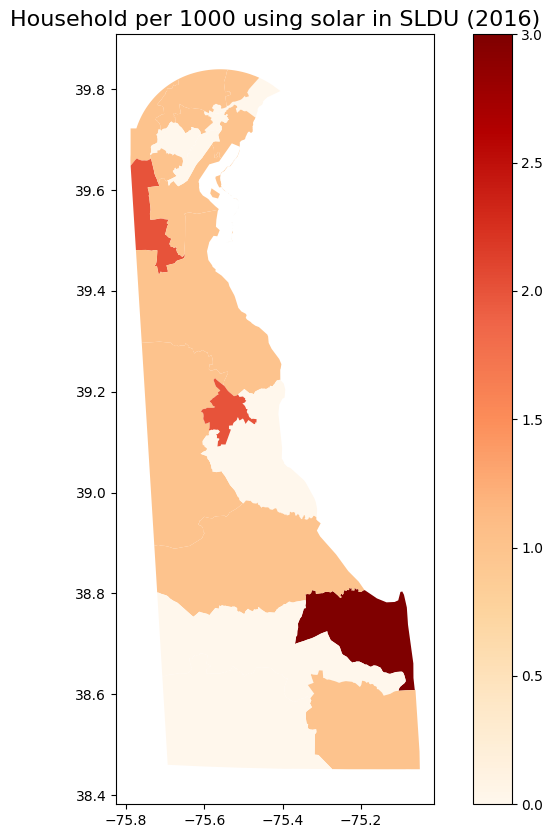

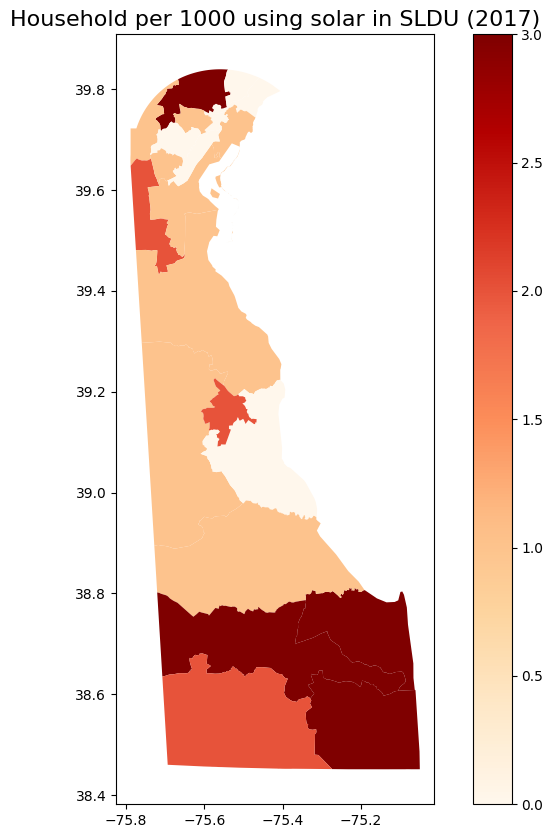

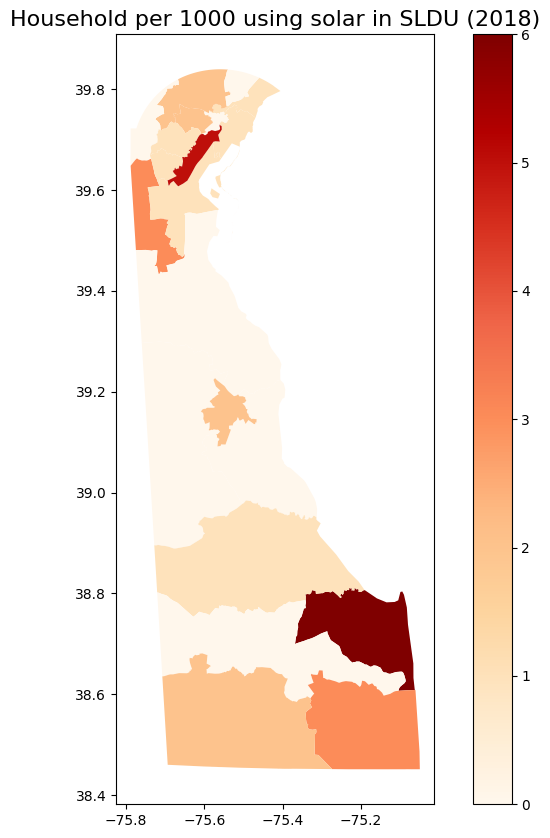

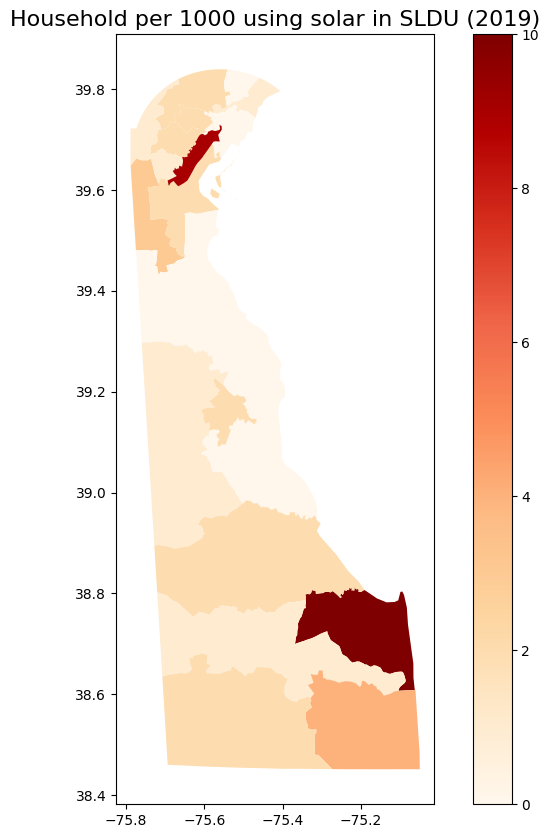

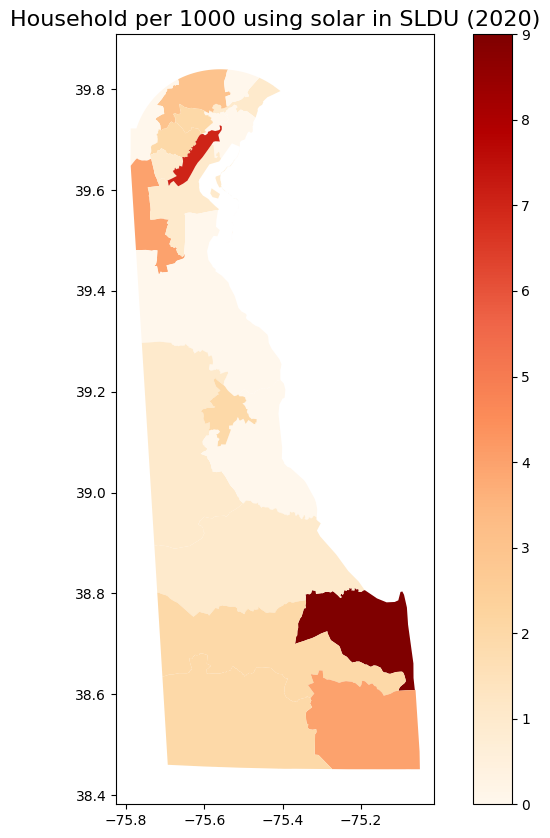

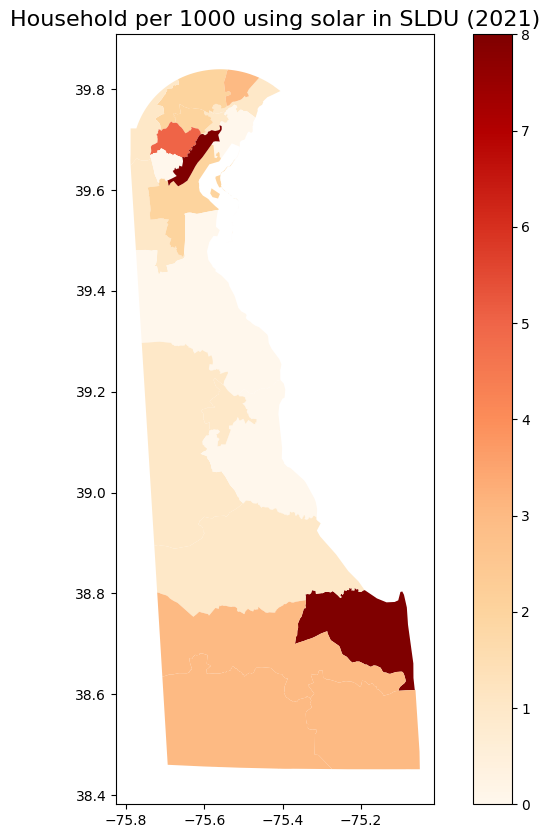

In [4]:
# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

EEIF_df = pd.read_csv("/Users/kamran/Downloads/DSHA/Energy_Efficiency_Investment_Fund__EEIF__Grants__FY_2017_to_Present.csv")

# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

# Create a GeoDataFrame from the latitude and longitude columns and engineering year feature
geometry = gpd.points_from_xy(EEIF_df['Longitude'], EEIF_df['Latitude'])
EEIF_gdf = gpd.GeoDataFrame(EEIF_df, geometry=geometry)
EEIF_gdf['Date'] = pd.to_datetime(EEIF_gdf['App Completed/to Fiscal Date'])
EEIF_gdf['year'] = EEIF_gdf['Date'].dt.strftime('%Y')
EEIF_gdf['% of cost'] = EEIF_gdf['Award, % of Total Project Cost']*100
EEIF_gdf.dropna(subset=['% of cost','year'], inplace=True)
EEIF_gdf = EEIF_gdf[['Name of Grantee','Final Award Amount','% of cost',
                     'Proposed Electricity Savings (kWh/yr)',
                     'Proposed Natural Gas Savings (kBtus/yr)','Greenhouse Gas Emission Reduction (MtCO2e)',
                     'year','geometry']]
EEIF_gdf.reset_index(drop=True,inplace=True)
EEIF_gdf.rename(columns={'Name of Grantee':'Name','Final Award Amount':'Award ($)',
                         'Proposed Electricity Savings (kWh/yr)':'Electricity Savings (kWh/yr)',
                         'Proposed Natural Gas Savings (kBtus/yr)':'Natural Gas Savings (kBtus/yr)'},inplace=True)

for i in range(2016,2022):

    year = str(i)

    usr_key = os.environ.get('CENSUS_API_KEY')

    host = 'https://api.census.gov/data'
    dataset_acronym = '/acs/acs5'
    g = '?get='
    variables = 'NAME,B01001_001E,B25003_002E,B25040_008E'
    location = '&for=state%20legislative%20district%20(upper%20chamber):*&in=state:10'

    # Put it all together in one f-string:
    query_url = f"{host}/{year}{dataset_acronym}{g}{variables}{location}&key={usr_key}"

    response = requests.get(query_url)

    # Create shapefile query URL
    shape_url = f"https://www2.census.gov/geo/tiger/TIGER{year}/SLDU/tl_{year}_10_sldu.zip"

    # Read the shapefile from the URL into a GeoPandas DataFrame
    sldu_gdf = gpd.read_file(shape_url)

    # Convert the JSON response to a list of lists (excluding the header)
    data = response.json()[1:]

    # Convert the list of lists into a DataFrame
    columns = response.json()[0]  # Use the first row as column names
    api_data_df = pd.DataFrame(data, columns=columns)
    api_data_df.rename(columns={'B01001_001E':'Total Population',
                               'B25003_002E':'Owner Occupied Households',
                               'B25040_008E':'Solar Households',
                               'state legislative district (upper chamber)':'District'},inplace=True)
    api_data_df.drop('state',axis=1,inplace=True)
    api_data_df = api_data_df.astype({'Total Population':'int64',
                                      'Owner Occupied Households':'int64',
                                      'Solar Households':'int64',
                                     'District':'int64'})
    api_data_df['Solar Households per 1000'] = round((api_data_df['Solar Households'] 
                                                      / api_data_df['Owner Occupied Households'])
                                                     * 1000, 0).astype('int64')
    names_df = pd.read_csv('/Users/kamran/Downloads/Datasets/senators.csv')
    api_data_df = names_df.merge(api_data_df, left_on="District", right_on="District")

    # Perform spatial join
    joined_gdf = gpd.sjoin(EEIF_gdf, sldu_gdf, how="left", op="within")

    # Find total values for the year.
    joined_gdf = pd.DataFrame(joined_gdf[joined_gdf['year']==year].groupby('index_right')[['Award ($)',
                                                                                           'Electricity Savings (kWh/yr)',
                                                                                           'Natural Gas Savings (kBtus/yr)',
                                                                                          'Greenhouse Gas Emission Reduction (MtCO2e)']].sum())

    # Adding total values for the year to api data.
    joined_gdf.rename(columns={"Award ($)":"Value of EEIF Grants Awarded",
                              'Electricity Savings (kWh/yr)':'EEIF Electricity Savings (kWh/yr)',
                              'Natural Gas Savings (kBtus/yr)':'EEIF Natural Gas Savings (kBtus/yr)',
                              'Greenhouse Gas Emission Reduction (MtCO2e)':'EEIF Greenhouse Gas Emission Reduction (MtCO2e)'},inplace=True)
    merged_df = api_data_df.merge(joined_gdf, how='left', left_on="District", right_on="index_right")
    merged_df.fillna(0, inplace=True)

    # Spatial intersection to retain only the parts within the dry land of Delaware
    delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')

    # Dissolve the GeoDataFrame based on the SLDUST column to eliminate duplicates
    delaware_land_gdf_dissolved = delaware_land_gdf.dissolve(by='SLDUST', aggfunc='first')
    delaware_land_gdf_dissolved.reset_index(inplace=True)
    delaware_land_gdf_dissolved['SLDUST'] = delaware_land_gdf_dissolved['SLDUST'].astype('int64')

    # Merge the DataFrame with the GeoDataFrame based on the common key
    output_gdf = delaware_land_gdf_dissolved.merge(merged_df, left_on="SLDUST", right_on="District")
    output_gdf = output_gdf[['Name','Total Population','Owner Occupied Households',
                         'Solar Households','Solar Households per 1000', 'Value of EEIF Grants Awarded',
                             'EEIF Electricity Savings (kWh/yr)','EEIF Natural Gas Savings (kBtus/yr)',
                             'EEIF Greenhouse Gas Emission Reduction (MtCO2e)','District','geometry']]
    print(output_gdf)

    # Save the merged GeoDataFrame as a GeoJSON file
    output_file = f"./DSHA_SLDU_all_years_rev2/SLDU_{year}.json"
    output_gdf.to_file(output_file, driver='GeoJSON')

    # Plot the merged GeoDataFrame with the added information from the DataFrame
    fig, ax = plt.subplots(figsize=(10, 10))
    output_gdf.plot(column="Solar Households per 1000", cmap="OrRd", legend=True, ax=ax)
    ax.set_title(f"Household per 1000 using solar in SLDU ({year})", fontsize=16)

    plt.savefig(f"./DSHA_SLDU_all_years_rev2/sldu_{year}.png", dpi=300)